In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM

from string import punctuation

Using TensorFlow backend.


In [3]:
df = pd.read_csv('dataset/newyork/ArticlesMay2017.csv', encoding='utf-8')

In [4]:
df.columns

Index(['abstract', 'articleID', 'articleWordCount', 'byline', 'documentType',
       'headline', 'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

In [5]:
df['headline']

0                            My Beijing: The Sacred City
1               6 Million Riders a Day, 1930s Technology
2                      Seeking a Cross-Border Conference
3      Questions for: ‘Despite the “Yuck Factor,” Lee...
4                                   Who Is a ‘Criminal’?
                             ...                        
991    Yes, You Can Write More Than One Letter in a S...
992               Trump’s Act  Of Gratuitous Destruction
993                           Petty Crime, Daunting Bail
994                                              Unknown
995    Bucking Trump, These Cities, States and Compan...
Name: headline, Length: 996, dtype: object

In [6]:
def Unknown_chk(model):
    cnt = 0
    for i in model:
        if i == 'Unknown':
            cnt += 1
    print("Unknown's Value:", cnt)

In [7]:
Unknown_chk(df['headline'])

Unknown's Value: 61


In [8]:
headline = [title for title in df['headline'] if title != 'Unknown']

In [9]:
Unknown_chk(headline)

Unknown's Value: 0


In [10]:
# 특수문자 제거 & 대문자 -> 소문자로 전환
def repreprocssing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [11]:
text = [repreprocssing(x) for x in headline]

In [12]:
text[:5]

['my beijing the sacred city',
 '6 million riders a day 1930s technology',
 'seeking a crossborder conference',
 'questions for despite the yuck factor leeches are big in russian medicine',
 'who is a criminal']

In [13]:
t = Tokenizer()

In [14]:
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1 

In [15]:
sequences = []
for line in text:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[48, 799],
 [48, 799, 1],
 [48, 799, 1, 800],
 [48, 799, 1, 800, 57],
 [114, 406],
 [114, 406, 407],
 [114, 406, 407, 2],
 [114, 406, 407, 2, 179],
 [114, 406, 407, 2, 179, 801],
 [114, 406, 407, 2, 179, 801, 802],
 [803, 2]]

In [16]:
max_len = max([len(s) for s in sequences])
max_len

16

In [17]:
sequences = pad_sequences(sequences, max_len)

In [18]:
x = sequences[:, :-1]
y = sequences[:, -1]
y = to_categorical(y, vocab_size)

In [19]:
x.shape, y.shape

((5501, 15), (5501, 2653))

In [20]:
def model_create(layers, em_units, units):
    model = Sequential([
        Embedding(vocab_size, em_units, input_length=max_len-1),
        layers(units),
        Dense(vocab_size, activation='softmax')
    ])
    
    return model

In [21]:
model = model_create(LSTM, 10, 128)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 10)            26530     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dense_1 (Dense)              (None, 2653)              342237    
Total params: 439,935
Trainable params: 439,935
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = model.fit(x, y, epochs=200, verbose = 0)

C:\Users\15\.conda\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
history.history['accuracy'][-1]

0.89529175

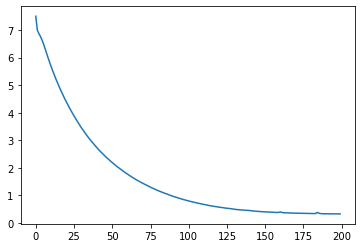

In [26]:
plt.plot(history.history['loss'])
plt.show()

In [37]:
def sentence_generation(model, t, current_word, n):
    word_init = current_word
    sentence = ''
    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], max_len-1)
        
        result = model.predict_classes(encoded, verbose=0)
        
        for word, index in t.word_index.items():
            if index == result:
                break
        current_word = current_word + ' ' + word
        
        sentence = sentence + ' ' + word
    sentence = word_init + sentence
    
    return sentence

In [38]:
df['headline'][0]

'My Beijing: The Sacred City'

In [39]:
print(sentence_generation(model, t, 'my Beijing', 3))

my Beijing the sacred city


In [40]:
df['headline'][1]

'6 Million Riders a Day, 1930s Technology'

In [41]:
print(sentence_generation(model, t, '6 Million',5))

6 Million riders a day 1930s technology


In [43]:
df['headline'][100]

'James Comey Is ‘Mildly Nauseous’ About the Election. It’s Not Enough.'

In [45]:
print(sentence_generation(model, t, 'James', 10))

James comey is mildly nauseous about the election its not enough
